In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [8]:
state = 'VA'
df = pd.read_csv('us-vaccines.csv').drop(['Code'],1)
vaccines_daily = df[df['Entity']=='Virginia']['people_vaccinated'].to_numpy().reshape(-1,1)


States to be worked on are: Northern Mariana Islands, Virgin Islands, Guam

Texas	, California, New York

Virginia

# Preprocessing Data

In [9]:
scaler = MinMaxScaler(feature_range=(-1.0,+1.0))
vaccines_cumulative_normalized = scaler.fit_transform(vaccines_daily)

In [10]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [11]:
window_size = 30

X,Y = convert_to_slide_window(vaccines_cumulative_normalized,window_size)
split = int(len(X) * 0.7)

X_train,y_train=X[:split],Y[:split]
X_test,y_test =X[split:],Y[split:]

# Cumulative + Non-Normalized
X_train, y_train = torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)
X_test, y_test  = torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

# Load into DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False)

# Cumulative + Non-Normalized
y_test_inverse = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# Non-Cumulative + Non-Normalized
y_test_daily_vaccines = cumulative_to_daily(y_test_inverse)


In [12]:
y_test_inverse.shape

(24, 1)

# TST Model

In [13]:
TST_model = TimeSeriesTransformer(n_features=1,d_model=512, n_heads=8, n_hidden=512, n_layers=8 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(TST_model.state_dict(), 'Weights/model_TST_{}_Vaccine'.format(state))
# TST_model.load_state_dict(torch.load('Weights/model_TST_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.316432848572731
Epoch 2 Loss is 0.2376377135515213
Epoch 3 Loss is 0.1739860624074936
Epoch 4 Loss is 0.14866891503334045
Epoch 5 Loss is 0.1505245454609394
Epoch 6 Loss is 0.07940430752933025
Epoch 7 Loss is 0.15038936585187912
Epoch 8 Loss is 0.11647443100810051
Epoch 9 Loss is 0.09397303685545921
Epoch 10 Loss is 0.08864062279462814
Epoch 11 Loss is 0.06769009120762348
Epoch 12 Loss is 0.0633356161415577
Epoch 13 Loss is 0.05865069851279259
Epoch 14 Loss is 0.05122378468513489
Epoch 15 Loss is 0.045898811891674995
Epoch 16 Loss is 0.04695818945765495
Epoch 17 Loss is 0.042727963998913765
Epoch 18 Loss is 0.031922358088195324
Epoch 19 Loss is 0.041181713342666626
Epoch 20 Loss is 0.023264430463314056
Epoch 21 Loss is 0.018330339342355728
Epoch 22 Loss is 0.030301621183753014
Epoch 23 Loss is 0.015710346400737762
Epoch 24 Loss is 0.012773605063557625
Epoch 25 Loss is 0.020949652418494225
Epoch 26 Loss is 0.008348988369107246
Epoch 27 Loss is 0.010836338624358177
Epoc

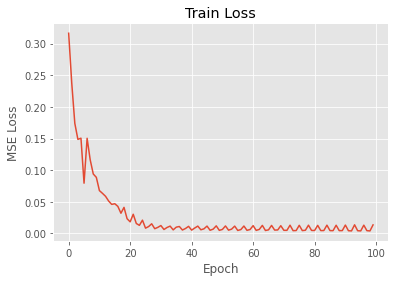

In [14]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [15]:
def test_TST(model, X):
    model.eval()
    torch.cuda.empty_cache()
    S = X.shape[1] # Sequence Length
    src_mask = model.generate_square_subsequent_mask(S)
    predicted = model(X.permute(1,0,2),None,None).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[-1,:,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('TST: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps
forecasted_TST = test_TST(TST_model, X=X_test)

TST: Test MSE Loss:  0.007852326147258282


In [16]:
X_train[-1].shape

torch.Size([30, 1])

In [17]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,],None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
        
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_TST = forecast_TST(TST_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0780, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [18]:
print("We used {} Parameters for the transformer model".format(count_parameters(TST_model)))

We used 12625409 Parameters for the transformer model


In [19]:
forecasted_inverse_TST = scaler.inverse_transform(forecasted_TST.cpu().detach().numpy())
forecasted_daily_vaccines_TST  = cumulative_to_daily(forecasted_inverse_TST)

In [20]:
print('R2 Score for Vaccines',r2_score(y_test.cpu().detach().numpy(),forecasted_TST.cpu().detach().numpy()))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test.cpu().detach().numpy(),forecasted_TST.cpu().detach().numpy()))

R2 Score for Vaccines 0.8596415650492614
MAPE Score for Vaccines 0.15493302


# LSTM Model

In [21]:
LSTM_model = COVID_LSTM(n_hidden=256,n_features=1).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0001)
all_epochs_loss = LSTM_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(LSTM_model.state_dict(), 'Weights/model_LSTM_{}_Vaccine'.format(state))
# LSTM_model.load_state_dict(torch.load('Weights/model_LSTM_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.23240914940834045
Epoch 2 Loss is 0.21407172828912735
Epoch 3 Loss is 0.20442833006381989
Epoch 4 Loss is 0.19388751685619354
Epoch 5 Loss is 0.18090897053480148
Epoch 6 Loss is 0.17047487199306488
Epoch 7 Loss is 0.15799109637737274
Epoch 8 Loss is 0.14947278052568436
Epoch 9 Loss is 0.13263622671365738
Epoch 10 Loss is 0.12440423667430878
Epoch 11 Loss is 0.11375657469034195
Epoch 12 Loss is 0.10096640512347221
Epoch 13 Loss is 0.09152746200561523
Epoch 14 Loss is 0.08521614968776703
Epoch 15 Loss is 0.0765455849468708
Epoch 16 Loss is 0.08108506351709366
Epoch 17 Loss is 0.084254689514637
Epoch 18 Loss is 0.08188808709383011
Epoch 19 Loss is 0.08143334835767746
Epoch 20 Loss is 0.07606031373143196
Epoch 21 Loss is 0.07505704835057259
Epoch 22 Loss is 0.07353535294532776
Epoch 23 Loss is 0.07330889999866486
Epoch 24 Loss is 0.07328835874795914
Epoch 25 Loss is 0.07077135518193245
Epoch 26 Loss is 0.07363303378224373
Epoch 27 Loss is 0.06848739087581635
Epoch 28 Loss

In [22]:
def test_LSTM(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('LSTM: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_LSTM = test_LSTM(LSTM_model, X=X_test)

LSTM: Test MSE Loss:  0.07733190804719925


In [23]:
X_test.shape

torch.Size([24, 30, 1])

In [24]:
def forecast_LSTM(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_LSTM = forecast_LSTM(LSTM_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.1371, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [25]:
forecasted_inverse_LSTM = scaler.inverse_transform(forecasted_LSTM.cpu().detach().numpy())
forecasted_daily_vaccines_LSTM  = cumulative_to_daily(forecasted_inverse_LSTM)

In [26]:
print('R2 Score for Vaccines',r2_score(y_test_daily_vaccines,forecasted_daily_vaccines_LSTM))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test_daily_vaccines,forecasted_daily_vaccines_LSTM))

R2 Score for Vaccines 0.9912663142685547
MAPE Score for Vaccines 0.55305696


# GRU Model

In [27]:
GRU_model = COVID_GRU(n_hidden=256,n_features=1).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.0001)
all_epochs_loss = GRU_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(GRU_model.state_dict(), 'Weights/model_GRU_{}_Vaccine'.format(state))
# GRU_model.load_state_dict(torch.load('Weights/model_GRU_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.2545509934425354
Epoch 2 Loss is 0.2206553816795349
Epoch 3 Loss is 0.1833764985203743
Epoch 4 Loss is 0.15351028740406036
Epoch 5 Loss is 0.1272818073630333
Epoch 6 Loss is 0.10782108083367348
Epoch 7 Loss is 0.08855042606592178
Epoch 8 Loss is 0.07992173358798027
Epoch 9 Loss is 0.07239563018083572
Epoch 10 Loss is 0.07414833456277847
Epoch 11 Loss is 0.07079758495092392
Epoch 12 Loss is 0.07706018909811974
Epoch 13 Loss is 0.0734574943780899
Epoch 14 Loss is 0.06986382603645325
Epoch 15 Loss is 0.0662982426583767
Epoch 16 Loss is 0.06244877353310585
Epoch 17 Loss is 0.05834408104419708
Epoch 18 Loss is 0.05695861950516701
Epoch 19 Loss is 0.0534797552973032
Epoch 20 Loss is 0.05198913440108299
Epoch 21 Loss is 0.05164201557636261
Epoch 22 Loss is 0.049130773171782494
Epoch 23 Loss is 0.0454261489212513
Epoch 24 Loss is 0.04185084439814091
Epoch 25 Loss is 0.038994163274765015
Epoch 26 Loss is 0.037102239206433296
Epoch 27 Loss is 0.031280760653316975
Epoch 28 Loss 

In [28]:
def test_GRU(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('GRU: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_GRU = test_GRU(GRU_model, X=X_test)

GRU: Test MSE Loss:  0.011892419308423996


In [29]:
X_test.shape

torch.Size([24, 30, 1])

In [30]:
def forecast_GRU(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_GRU = forecast_GRU(GRU_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0808, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [31]:
forecasted_inverse_GRU = scaler.inverse_transform(forecasted_GRU.cpu().detach().numpy())
forecasted_daily_vaccines_GRU  = cumulative_to_daily(forecasted_inverse_GRU)

In [32]:
print('R2 Score for Vaccines',r2_score(y_test_daily_vaccines,forecasted_daily_vaccines_GRU))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test_daily_vaccines,forecasted_daily_vaccines_GRU))

R2 Score for Vaccines 0.9961519863045362
MAPE Score for Vaccines 0.32819176


# Plots

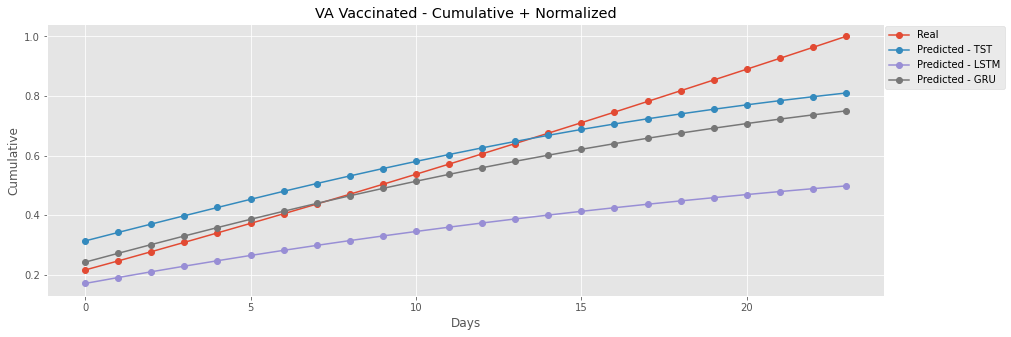

In [33]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,0].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,0].cpu().detach().numpy(),label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,0].cpu().detach().numpy(),label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,0].cpu().detach().numpy(),label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Cumulative + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

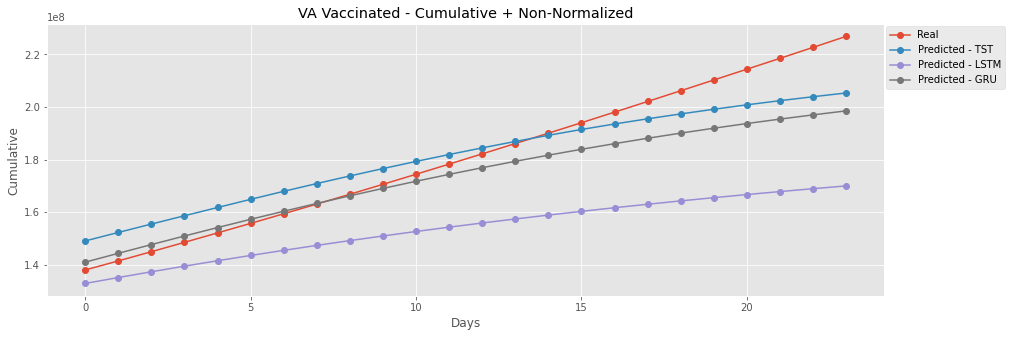

In [34]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,0],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,0],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Cumulative + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()